In [ ]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import TimeSeriesTensor, mape, extract_data, create_evaluation_df
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
!git clone https://github.com/Arghyam-Team/KRSPrediction.git

Cloning into 'KRSPrediction'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 236 (delta 98), reused 112 (delta 33), pack-reused 0
Receiving objects: 100% (236/236), 4.94 MiB | 9.72 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
import sqlite3
db_file = '/content/KRSPrediction/data/pythonsqlite.db'
conn = sqlite3.connect(db_file)
cur = conn.cursor()
sql = "SELECT water.date, water.storage_tmc, water.inflow_cusecs, water.outflow_cusecs, weather.max_temp, weather.visibility, weather.wind, weather.humidity, weather.cloudcover FROM water INNER JOIN weather ON  water.reservoir='krs' AND weather.location='karnataka' AND water.date = weather.date"
cur.execute(sql)
rows = cur.fetchall() # rows is a list of tuples (date, tmc,inflow,outflow,maxtemp,vis,wind,hum,cloud)

In [ ]:
krs = pd.DataFrame(rows, columns=['date', 'present_storage_tmc', 'inflow', 'outflow', 'max_temp', 'visibility', 'wind', 'humidity', 'cloudcover'])

In [ ]:
krs.head(2)

,date,present_storage_tmc,inflow,outflow,max_temp,visibility,wind,humidity,cloudcover
0,2011-01-01,46.42,2029,2000.0,28.1,6.7,11.2,71.39,36.7
1,2011-01-02,46.54,3084,1490.0,28.0,6.2,10.3,72.90,51.4


In [ ]:
krs = krs.drop_duplicates(subset=["date"])

In [ ]:
krs.date = pd.to_datetime(krs.date)
krs['inflow'] = pd.to_numeric(krs.inflow, errors='coerce')

In [ ]:
krs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3535
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3531 non-null   datetime64[ns]
 1   present_storage_tmc  3531 non-null   float64       
 2   inflow               3530 non-null   float64       
 3   outflow              3531 non-null   float64       
 4   max_temp             3531 non-null   float64       
 5   visibility           3531 non-null   float64       
 6   wind                 3531 non-null   float64       
 7   humidity             3531 non-null   float64       
 8   cloudcover           3531 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 275.9 KB


In [ ]:
krs['inflow_tmc'] = krs['inflow'] /11000
krs['outflow_tmc'] = krs['outflow'] / 11000

In [ ]:
krs.sort_values(by=['date'], inplace=True, ascending=True)

In [ ]:
krs.set_index('date', inplace=True)
krs = krs.sort_index(axis=1)

In [ ]:
krs.head(2)

,cloudcover,humidity,inflow,inflow_tmc,max_temp,outflow,outflow_tmc,present_storage_tmc,visibility,wind
date,,,,,,,,,,
2010-09-30,79.6,81.05,2706.0,0.246000,29.4,6840.0,0.621818,46.18,5.2,11.2
2010-12-31,51.0,70.80,2668.0,0.242545,27.5,6795.0,0.617727,45.81,6.9,11.2


In [ ]:
#time series data on which model needs to be trained on, features contain the column names
ts_data_load = krs[[ "present_storage_tmc", "inflow_tmc", "outflow_tmc", "max_temp", "visibility", "humidity", "wind"]]
ts_data_load.sort_index(axis = 1)
features = len(ts_data_load.columns)
#features, ts_data_load.head(2), ts_data_load.tail(2)

In [ ]:
valid_st_data_load = "2018-01-01 00:00:00"
test_st_data_load = "2019-05-02 00:00:00"

In [ ]:
ts_data_load[ts_data_load.index==valid_st_data_load]

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-01-01,25.55,0.026455,0.313182,28.0,6.6,65.5,11.0


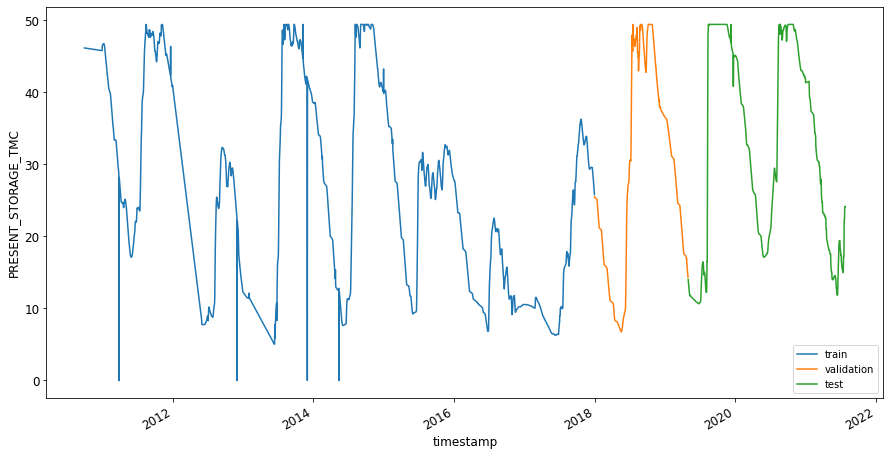

In [ ]:
ts_data_load[ts_data_load.index < valid_st_data_load][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["present_storage_tmc"]
    ].rename(columns={"present_storage_tmc": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("PRESENT_STORAGE_TMC", fontsize=12)
plt.show()

In [ ]:
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load]

In [ ]:
train.shape

(2250, 7)

In [ ]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["present_storage_tmc"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
flist = list(ts_data_load.columns)

In [ ]:
T = 30
HORIZON = 15
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][flist]

X_scaler = MinMaxScaler()
train[flist] = X_scaler.fit_transform(train)
train.sample(10)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2016-03-17,0.280485,0.003384,0.034538,0.700935,0.683333,0.490187,0.086124
2017-12-12,0.598180,0.009189,0.004137,0.392523,0.266667,0.653925,0.025974
2012-07-13,0.194135,0.018001,0.028748,0.537383,0.683333,0.598272,0.127820
2013-07-08,0.591709,0.301328,0.035603,0.467290,0.700000,0.575864,0.179768
2014-09-25,1.000000,0.164866,0.050976,0.649533,0.650000,0.775630,0.109364
2017-05-29,0.130839,0.005532,0.003569,0.556075,0.816667,0.664616,0.151743
2015-02-09,0.708797,0.003562,0.005760,0.672897,0.616667,0.408612,0.082707
2013-09-24,1.000000,0.090695,0.085656,0.415888,0.666667,0.618776,0.127820
2011-12-08,0.896259,0.046909,0.064929,0.373832,0.566667,0.632542,0.103213


In [ ]:
train = train.dropna(axis = 0, how ='any')
train.isna().sum()

present_storage_tmc    0
inflow_tmc             0
outflow_tmc            0
max_temp               0
visibility             0
humidity               0
wind                   0
dtype: int64

In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}
print(tensor_structure)
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    days=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= back_ts_data) & (ts_data_load.index < test_st_data_load)][
    flist
]
valid[flist] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "present_storage_tmc", HORIZON, tensor_structure, freq='D')

{'X': (range(-29, 1), ['present_storage_tmc', 'inflow_tmc', 'outflow_tmc', 'max_temp', 'visibility', 'humidity', 'wind'])}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [ ]:
LATENT_DIM = T
BATCH_SIZE = 32
EPOCHS = (
    100
)

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, return_sequences=True,input_shape=(T, features)))
#model.add(GRU(LATENT_DIM, input_shape=(T, 3)))
model.add(GRU(LATENT_DIM))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer="adam", loss="mse")


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 30)            3510      
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense (Dense)                (None, 15)                465       
Total params: 9,555
Trainable params: 9,555
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/100
61/61 [==============================] - 6s 40ms/step - loss: 0.1132 - val_loss: 0.0312
Epoch 2/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0110 - val_loss: 0.0066
Epoch 3/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 4/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 5/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 6/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 7/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 8/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 9/100
61/61 [==============================] - 2s 27ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 10/100
61/61 [==============================] - 2s 28ms/step - loss: 0.0029 - val_loss: 0.0044

In [ ]:
model.save("30daysto15days")

INFO:tensorflow:Assets written to: 30daysto15days/assets


INFO:tensorflow:Assets written to: 30daysto15days/assets


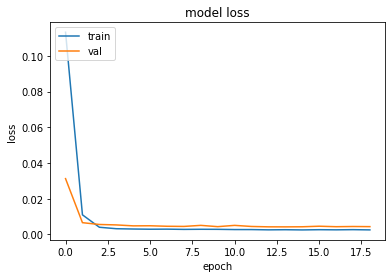

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

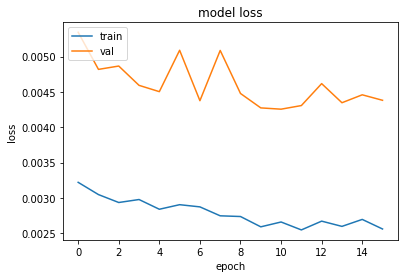

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'][3:])
plt.plot(model_history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ts_data_test = ts_data_load.copy()[test_st_data_load:][flist]
ts_data_test[flist] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "present_storage_tmc", HORIZON, tensor_structure, freq='D')


In [ ]:
ts_data_test_inputs['X'].shape

(649, 30, 7)

In [ ]:
def create_evaluation_df1(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(
        predictions, columns=["t+" + str(t) for t in range(1, H + 1)]
    )
    
    eval_df["timestamp"] = test_inputs.dataframe.index
    print(eval_df.shape, eval_df.head(2))

    #eval_df = pd.melt(
    #    eval_df, id_vars="timestamp", value_name="prediction", var_name="h"
    #)
    values = ['t+'+str(i) for i in range(1, H+1)]
    
    eval_df = pd.melt(
        eval_df, id_vars="timestamp", value_vars=values, value_name="prediction"
    )
    print(eval_df.shape, eval_df.head(2))
    eval_df["actual"] = np.transpose(test_inputs["target"]).ravel()
    eval_df[["prediction", "actual"]] = scaler.inverse_transform(
        eval_df[["prediction", "actual"]]
    )
    return eval_df

In [ ]:
ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df1(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.sample(5)

(649, 16)         t+1       t+2       t+3  ...      t+14      t+15  timestamp
0  0.218657  0.213530  0.226029  ...  0.242759  0.254688 2019-05-31
1  0.220487  0.212425  0.223417  ...  0.240380  0.255062 2019-06-01

[2 rows x 16 columns]
(9735, 3)    timestamp variable  prediction
0 2019-05-31      t+1    0.218657
1 2019-06-01      t+1    0.220487


,timestamp,variable,prediction,actual
9047,2021-06-03,t+14,16.234364,12.885286
87,2019-08-26,t+1,46.375769,49.450000
6099,2020-03-29,t+10,24.421289,26.020000
429,2020-12-04,t+1,42.825067,43.430000
7879,2019-08-30,t+13,46.911444,49.450000


In [ ]:
ts_predictions.shape

(649, 15)

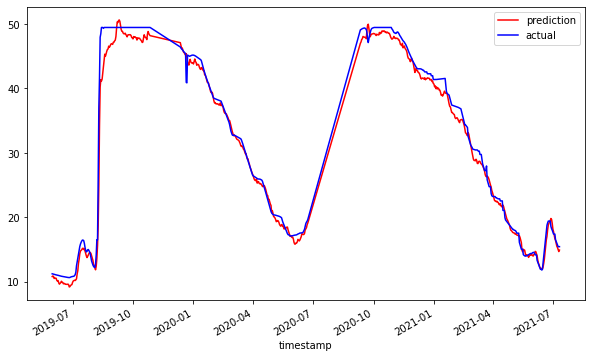

In [ ]:
ev_ts_data[ev_ts_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:

mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.057419848066487235

In [ ]:
ev_ts_data.to_csv("forecast_withdatecolumns.csv")

In [ ]:
import datetime
forecast_dates = ev_ts_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_ts_data["date"] = forecast_dates


In [ ]:
ev_ts_data.head(2)

,timestamp,variable,prediction,actual,date
0,2019-05-31,t+1,10.81257,11.25,2019-06-01
1,2019-06-01,t+1,10.90306,11.22,2019-06-02


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#finetuning
T = 30
HORIZON = 15
ftrain = ts_data_load.copy()[flist]

X_scaler = MinMaxScaler()
ftrain[flist] = X_scaler.fit_transform(ftrain)
ftrain.sample(2)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2011-11-20,0.950455,0.019324,0.045612,0.364486,0.204762,0.538265,0.103848
2016-04-07,0.242063,0.000828,0.005523,0.747664,0.219048,0.379100,0.067475


In [ ]:
ftrain.last('1D')

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2021-07-26,0.488493,0.053957,0.015142,0.35514,1.0,0.650149,0.129151


In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}

ts_train_inp = TimeSeriesTensor(
    dataset=ftrain,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
#back_ts_data = dt.datetime.strptime(date.today(), "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    days=T - 1
#)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=20,
    #validation_data=(valid_inputs["X"], valid_inputs["target"]),
    #callbacks=[earlystop],
    verbose=1,
)

Epoch 1/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0035
Epoch 2/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0033
Epoch 3/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0033
Epoch 4/20
99/99 [==============================] - 3s 26ms/step - loss: 0.0032
Epoch 5/20
99/99 [==============================] - 3s 26ms/step - loss: 0.0032
Epoch 6/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0031
Epoch 7/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0031
Epoch 8/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0030
Epoch 9/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0030
Epoch 10/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0030
Epoch 11/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0030
Epoch 12/20
99/99 [==============================] - 3s 27ms/step - loss: 0.0030
Epoch 13/20
99/99 [==================

In [ ]:
ts_predictions = model.predict(ts_train_inp["X"])

ev_all_data = create_evaluation_df1(ts_predictions, ts_train_inp, HORIZON, y_scaler)
ev_all_data.sample(5)

(3144, 16)         t+1       t+2       t+3  ...      t+14      t+15  timestamp
0  0.822087  0.824128  0.806362  ...  0.763193  0.752392 2011-01-29
1  0.817234  0.818767  0.801235  ...  0.760760  0.750190 2011-01-30

[2 rows x 16 columns]
(47160, 3)    timestamp variable  prediction
0 2011-01-29      t+1    0.822087
1 2011-01-30      t+1    0.817234


,timestamp,variable,prediction,actual
25105,2021-05-26,t+8,14.605688,14.580
18842,2021-06-20,t+6,17.850588,19.431
41479,2014-01-14,t+14,33.927642,34.120
5194,2018-03-12,t+2,13.348566,13.340
34361,2020-12-01,t+11,41.581798,43.040


In [ ]:
model.save("30daysto15days")

INFO:tensorflow:Assets written to: 30daysto15days/assets


INFO:tensorflow:Assets written to: 30daysto15days/assets


In [ ]:
cp -r '/content/30daysto15days/' '/content/gdrive/My Drive/Wave2web/'

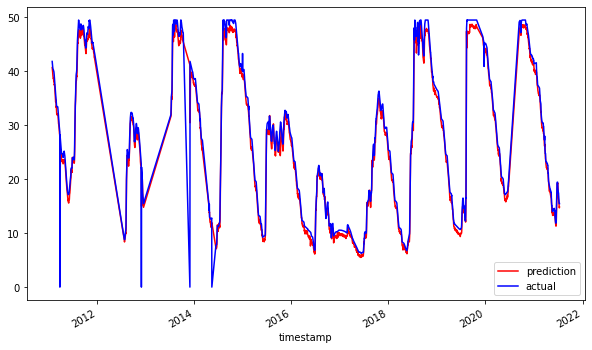

In [ ]:
ev_all_data[ev_all_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:
ximport datetime
forecast_dates = ev_all_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_all_data["date"] = forecast_dates


In [ ]:
ev_all_data.sample(20)

,timestamp,variable,prediction,actual,date
72708,2021-01-08,t+26,37.763987,37.237,2021-02-03
42547,2014-08-08,t+16,50.640675,48.250,2014-08-24
74546,2017-10-17,t+27,31.257775,33.310,2017-11-13
14896,2015-08-22,t+6,29.769914,26.920,2015-08-28
50776,2012-10-07,t+19,27.683343,30.070,2012-10-26
22522,2011-06-06,t+9,18.153354,19.830,2011-06-15
36484,2011-04-14,t+14,21.806799,25.040,2011-04-28
46172,2016-11-07,t+17,9.020504,9.910,2016-11-24
71319,2016-08-19,t+26,15.588709,14.640,2016-09-14
11951,2015-04-02,t+5,19.603572,19.720,2015-04-07


In [ ]:
ev_all_data.to_csv("predictions.csv")

In [ ]:
import sqlite3


In [ ]:
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

In [ ]:
df = pd.read_csv("predictions.csv")

In [ ]:
df.head()

,Unnamed: 0,timestamp,variable,prediction,actual,date
0,0,2011-01-29,t+1,41.820400,41.79,2011-01-30
1,1,2011-01-30,t+1,41.589464,41.56,2011-01-31
2,2,2011-01-31,t+1,41.276625,41.30,2011-02-01
3,3,2011-02-01,t+1,41.035273,40.98,2011-02-02
4,4,2011-02-02,t+1,40.736331,40.66,2011-02-03


In [ ]:
c.execute("CREATE TABLE PREDICTIONS ([timestamp] integer, [prediction] integer, [actual] integer, [date] integer)")

In [ ]:
conn.commit()

In [ ]:
conn = sqlite3.connect('predictions.db')  
c = conn.cursor()

In [ ]:
df[['timestamp', 'prediction', 'actual', 'date']].to_sql('PREDICTIONS', conn, if_exists='append', index = False)